In [7]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import classification_report, precision_score, recall_score

import joblib

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "svg" # to be replaced by "iframe" if working on JULIE

# 1. EDA

In [2]:
data = pd.read_csv('src/conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)
data.head()

Set with labels (our train+test) : (284580, 6)


,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


In [3]:
# The dataset is quite big : you must create a sample of the dataset before making any visualizations !
data_sample = data.sample(10000)

In [4]:
# Basic stats
print("Number of rows : {}".format(data_sample.shape[0]))

print("Display of dataset: ")
display(data_sample.head())

print("Basics statistics: ")
df_desc = data_sample.describe(include='all')
display(df_desc)

print("Percentage of missing values: ")
display(100*data_sample.isnull().sum()/data_sample.shape[0])

Number of rows : 10000
Display of dataset: 


,country,age,new_user,source,total_pages_visited,converted
105952,US,29,1,Seo,18,1
10543,US,22,1,Ads,4,0
236006,US,25,1,Ads,5,0
143141,US,47,1,Direct,2,0
33815,China,38,0,Seo,8,0


Basics statistics: 


,country,age,new_user,source,total_pages_visited,converted
count,10000,10000.000000,10000.000000,10000,10000.000000,10000.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,5652,NaN,NaN,4984,NaN,NaN
mean,NaN,30.597800,0.683000,NaN,4.910200,0.033200
std,NaN,8.325381,0.465331,NaN,3.347366,0.179167
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000


Percentage of missing values: 


country                0.0
age                    0.0
new_user               0.0
source                 0.0
total_pages_visited    0.0
converted              0.0
dtype: float64

    - no missing values
    - categortical feature: country, new_user, source
    - numerical features: age, total_page_visited
    - target: converted (categorical already encoded)

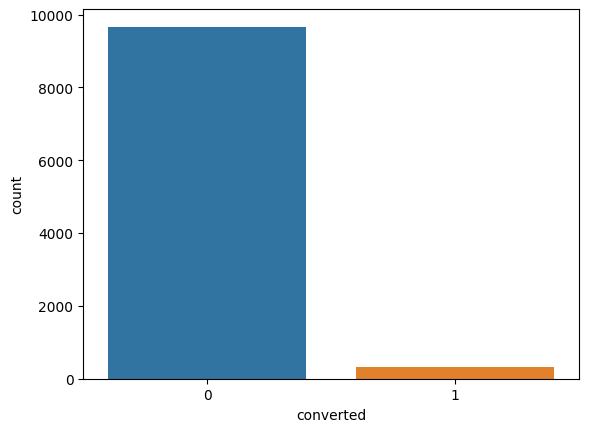

In [5]:
# countplot on the target: balanced categories?
sns.countplot(data=data_sample, x='converted');

# if unbalanced, to use: F1-score

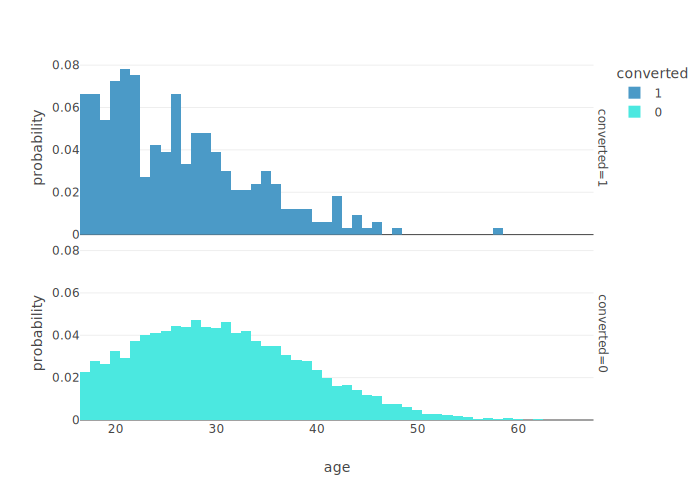

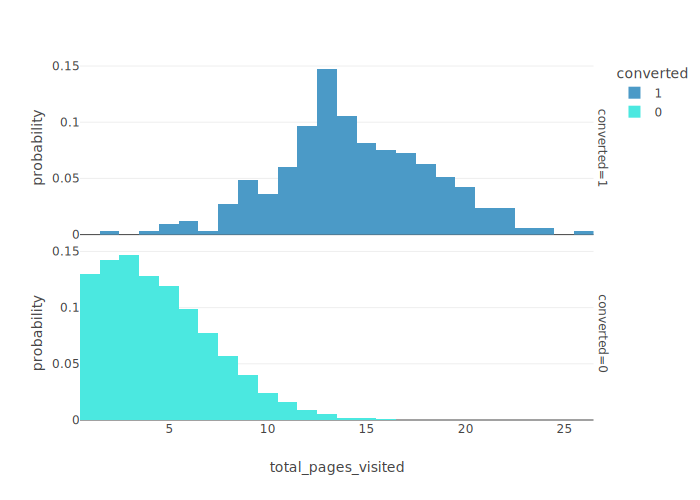

In [6]:
# Univariate analysis
# Distribution of each numeric variable
num_features = ['age', 'total_pages_visited']
for f in num_features:
    fig = px.histogram(data_sample, f, color = 'converted', facet_row = 'converted', histnorm = 'probability', height=500, width=700)
    fig.show()

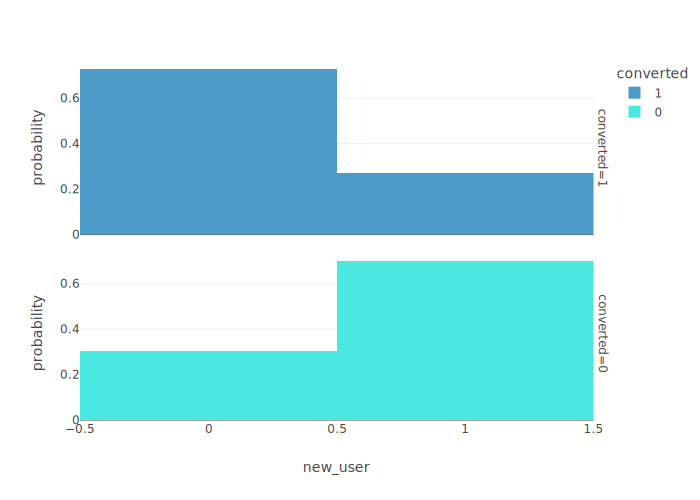

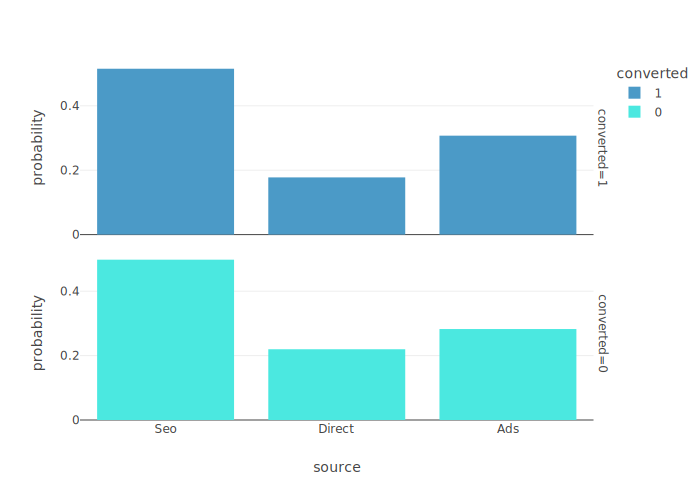

In [7]:
# Univariate analysis
# Distribution of each catagorical variables
num_features = ['new_user', 'source']
for f in num_features:
    fig = px.histogram(data_sample, f, color = 'converted', facet_row = 'converted', histnorm = 'probability', height=500, width=700)
    fig.show()

    - new_user and total_pages_visited are good candidates for logistic regression

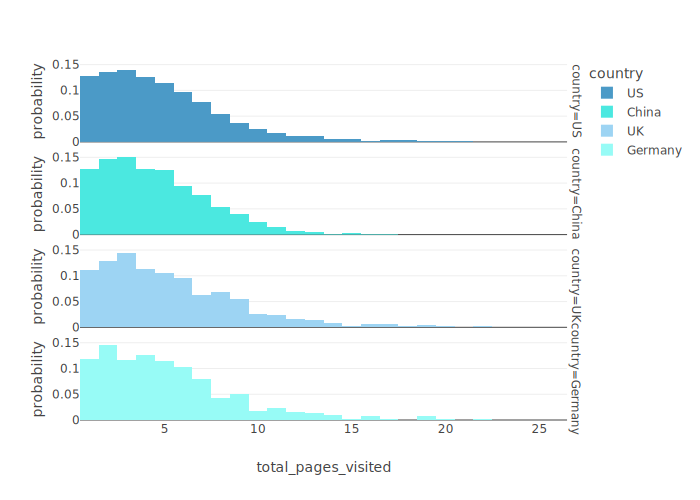

In [8]:
# Distribution of each category of the country variable
num_features = ['total_pages_visited']
for f in num_features:
    fig = px.histogram(data_sample, f, color = 'country', facet_row = 'country', histnorm = 'probability', height=500, width=700)
    fig.show()

# 2. Baseline model

In [9]:
# selection of the feature
features_list = ['total_pages_visited']
numeric_indices = [0]
categorical_indices = []
target_variable = 'converted'

# separation of the data
X = data.loc[:, features_list]
Y = data.loc[:, target_variable]

print('Explanatory variables : ', X.columns)

# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify = Y)
print("...Done.")

Explanatory variables :  Index(['total_pages_visited'], dtype='object')
Dividing into train and test sets...
...Done.


In [10]:
# Put here all the preprocessings
print("Encoding categorical features and standardizing numerical features...")
featureencoder = StandardScaler()
X_train = featureencoder.fit_transform(X_train)
print("...Done")
print(X_train[0:5,:])

print("Encoding categorical features and standardizing numerical features...")
X_test = featureencoder.transform(X_test)
print("...Done")
print(X_test[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[-1.15935344]
 [ 0.03743241]
 [-0.86015697]
 [-1.15935344]
 [ 0.03743241]]
Encoding categorical features and standardizing numerical features...
...Done
[[-1.15935344]
 [ 0.03743241]
 [-1.15935344]
 [-1.15935344]
 [-0.56096051]]


In [11]:
# Train model
print("Train model...")
baseline = LogisticRegression(class_weight='balanced')
baseline.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


In [12]:
# predicted values
Y_train_pred = baseline.predict(X_train)
Y_test_pred = baseline.predict(X_test)

In [13]:
# Print scores
print("f1-score on training set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on training set :  0.49292355950558275
f1-score on test set :  0.48934585009685594


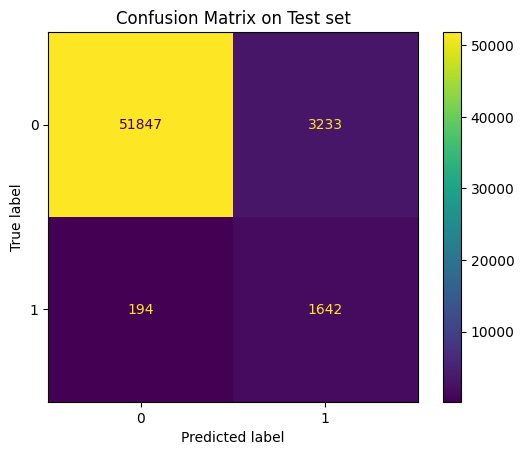

In [14]:
# Visualize confusion matrices
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(baseline, X_test, Y_test, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

# 3. feature selection by logistic regression

## 3.1 LogReg on all features

##### preprocessing

In [3]:
# selection of the feature
target_variable = 'converted'
features_list = ['country', 'age', 'new_user', 'source', 'total_pages_visited']

# separation of the data
X = data.loc[:, features_list]
Y = data.loc[:, target_variable]

print('Explanatory variables : ', X.columns)

# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify = Y)
print("...Done.")

Explanatory variables :  Index(['country', 'age', 'new_user', 'source', 'total_pages_visited'], dtype='object')
Dividing into train and test sets...
...Done.


In [4]:
# Create pipeline for numeric features
numeric_features = ['age', 'total_pages_visited']
numeric_transformer = StandardScaler()

# Create pipeline for categorical features
categorical_features = ['country', 'new_user', 'source']
categorical_transformer = Pipeline(
    steps=[
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [5]:
# Put here all the preprocessings
print("Encoding categorical features and standardizing numerical features...")
X_train = preprocessor.fit_transform(X_train)
print("...Done")

print("Encoding categorical features and standardizing numerical features...")
X_test = preprocessor.transform(X_test)
print("...Done")

Encoding categorical features and standardizing numerical features...
...Done
Encoding categorical features and standardizing numerical features...
...Done


##### model and performances

In [18]:
# Train model
print("Train model...")
logall = LogisticRegression()
logall.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


In [19]:
# predicted values
Y_train_predA = logall.predict(X_train)
Y_test_predA = logall.predict(X_test)

# Print scores
print("f1-score on training set : ", f1_score(Y_train, Y_train_predA))
print("f1-score on test set : ", f1_score(Y_test, Y_test_predA))

f1-score on training set :  0.7654507084715104
f1-score on test set :  0.7554347826086957


In [78]:
print("10-fold cross-validation...")
scores = cross_val_score(logall, X_train, Y_train, cv=10, scoring="f1")
print('The cross-validated F1-score is : ', scores.mean())
print('The standard deviation is : ', scores.std())

10-fold cross-validation...
The cross-validated F1-score is :  0.7656079915771271
The standard deviation is :  0.008775437864122444


    - still low score...
    - adding more features do not improve a lot the final F1-score: logistic regression may be not the best model for this dataset

In [20]:
column_names = []
for name, pipeline, features_list in preprocessor.transformers_: # loop over pipelines
    if name == 'num': # if pipeline is for numeric variables
        features = features_list # just get the names of columns to which it has been applied
    else: # if pipeline is for categorical variables
        features = pipeline.named_steps['encoder'].get_feature_names_out() # get output columns names from OneHotEncoder
    column_names.extend(features) # concatenate features names
        
print("Names of columns corresponding to each coefficient: ", column_names)

# Create a pandas DataFrame
coefs = pd.DataFrame(index = column_names, data = logall.coef_.transpose(), columns=["coefficients"])

# Compute abs() and sort values
feature_importance = abs(coefs).sort_values(by = 'coefficients')
feature_importance

Names of columns corresponding to each coefficient:  ['age', 'total_pages_visited', 'country_Germany', 'country_UK', 'country_US', 'new_user_1', 'source_Direct', 'source_Seo']


,coefficients
source_Seo,0.044345
source_Direct,0.197322
age,0.594201
new_user_1,1.687873
total_pages_visited,2.548630
country_US,3.055159
country_UK,3.426834
country_Germany,3.576552


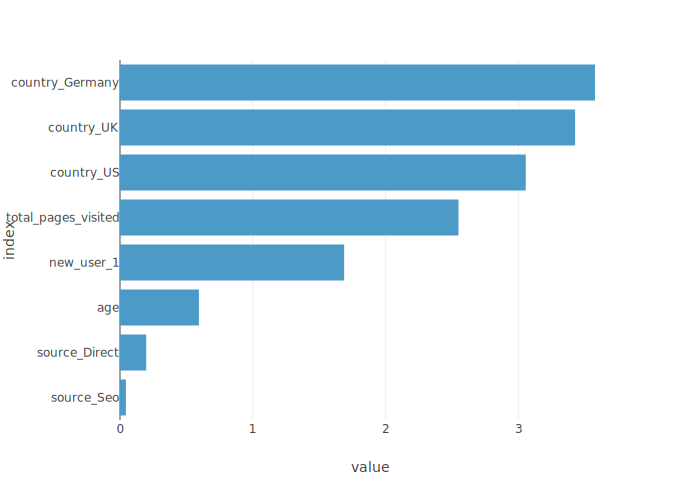

In [21]:
# Plot coefficients
fig = px.bar(feature_importance, orientation = 'h')
fig.update_layout(showlegend = False, 
                  margin = {'l': 120} # to avoid cropping of column names
                 )
fig.show()

    - all the feature contributed to the model despite a not so high performance. Decision tree and Random forest should be tested

In [64]:
# saving model
joblib.dump(logall, "models/logall.joblib")

['models/logall.joblib']

## 3.2 gridsearch on logistic regression

In [22]:
# Perform grid search
print("Grid search...")
LogRegG = LogisticRegression()
# Grid of values to be tested
params = {
    'penalty': ['l2'],
    'C': [0.15, 0.2, 0.25, 0.3]
}
gridsearchLR = GridSearchCV(LogRegG, param_grid = params, cv = 10)
gridsearchLR.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearchLR.best_params_)

Grid search...
...Done.
Best hyperparameters :  {'C': 0.15, 'penalty': 'l2'}


f1-score on training set :  0.7650702523039733
f1-score on test set :  0.7535530692470517


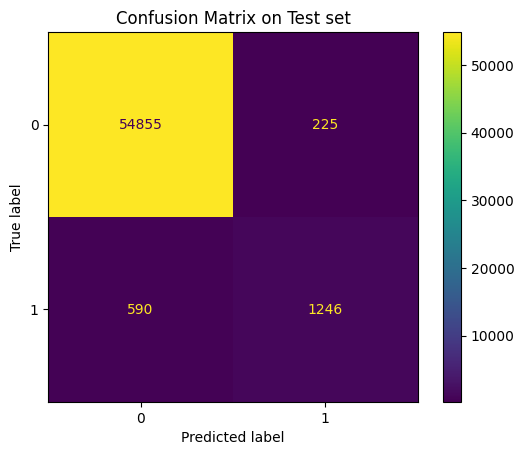

In [23]:
## predictions produced by the model
Y_train_predLR = gridsearchLR.predict(X_train)
Y_test_predLR = gridsearchLR.predict(X_test)
## probabilities produced by the model
Y_train_probaLR = gridsearchLR.predict_proba(X_train)
Y_test_probaLR = gridsearchLR.predict_proba(X_test)

## F1-score of the model
print("f1-score on training set : ", f1_score(Y_train, Y_train_predLR))
print("f1-score on test set : ", f1_score(Y_test, Y_test_predLR))

# plot
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(gridsearchLR, X_test, Y_test, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

In [80]:
print("10-fold cross-validation...")
scores = cross_val_score(gridsearchLR, X_train, Y_train, cv=10, scoring="f1")
print('The cross-validated F1-score is : ', scores.mean())
print('The standard deviation is : ', scores.std())

10-fold cross-validation...
The cross-validated F1-score is :  0.7647565085809094
The standard deviation is :  0.007894168524133422


# 4. random forest all features

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

## 4.1 decision tree

In [25]:
## reusing the same training and test set than the complete logistic regression
# Perform grid search
print("Grid search...")
classifierT = DecisionTreeClassifier()

# Grid of values to be tested
params = {
    'min_weight_fraction_leaf': [0, 0.2, 0.4, 0.5],
    'max_depth': [4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 5],
    'min_samples_split': [2, 4, 8]
}
gridsearchT = GridSearchCV(classifierT, param_grid = params, cv = 10) # cv : the number of folds to be used for CV
gridsearchT.fit(X_train, Y_train)
print("...Done.")

Grid search...
...Done.


In [26]:
print("Best hyperparameters : ", gridsearchT.best_params_)
print("Best validation accuracy : ", gridsearchT.best_score_)

Best hyperparameters :  {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 8, 'min_weight_fraction_leaf': 0}
Best validation accuracy :  0.9855664535412219


f1-score on training set :  0.7740665000378701
f1-score on test set :  0.7417982989064398


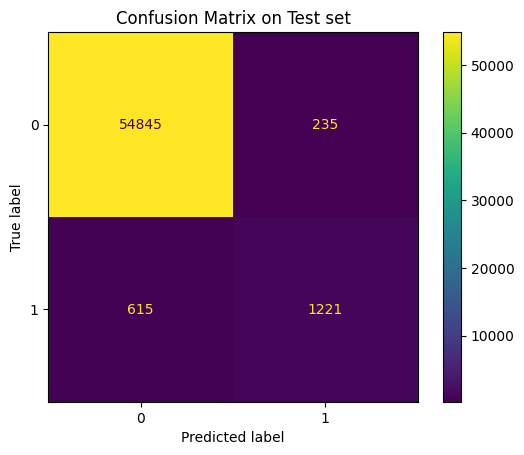

In [27]:
## predictions produced by the model
Y_train_predT = gridsearchT.predict(X_train)
Y_test_predT = gridsearchT.predict(X_test)
## probabilities produced by the model
Y_train_probaT = gridsearchT.predict_proba(X_train)
Y_test_probaT = gridsearchT.predict_proba(X_test)

## F1-score of the model
print("f1-score on training set : ", f1_score(Y_train, Y_train_predT))
print("f1-score on test set : ", f1_score(Y_test, Y_test_predT))

# plot
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(gridsearchT, X_test, Y_test, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

Names of columns corresponding to each coefficient:  ['age', 'total_pages_visited', 'country_Germany', 'country_UK', 'country_US', 'new_user_1', 'source_Direct', 'source_Seo']


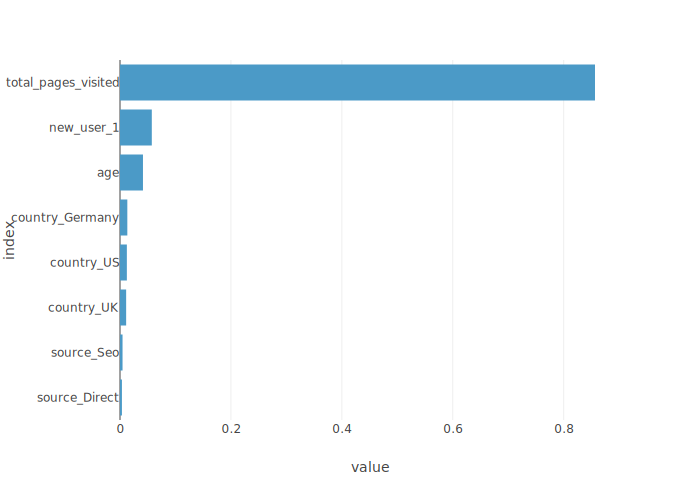

In [28]:
# feature importance
column_names = []
for name, step, features_list in preprocessor.transformers_: # loop over steps of ColumnTransformer
    if name == 'num': # if pipeline is for numeric variables
        features = features_list # just get the names of columns to which it has been applied
    else: # if pipeline is for categorical variables
        features = step.get_feature_names_out() # get output columns names from OneHotEncoder
    column_names.extend(features) # concatenate features names

print("Names of columns corresponding to each coefficient: ", column_names)

# Create a pandas DataFrame
feature_importance = pd.DataFrame(index = column_names, data = gridsearchT.best_estimator_.feature_importances_, columns=["feature_importances"])
feature_importance = feature_importance.sort_values(by = 'feature_importances')

# Plot coefficients
fig = px.bar(feature_importance, orientation = 'h')
fig.update_layout(showlegend = False, 
                  margin = {'l': 120} # to avoid cropping of column names
                 )
fig.show()

In [29]:
print("Classification report on train set:")
print(classification_report(Y_train, Y_train_predT))

print("Classification report on test set:")
print(classification_report(Y_test, Y_test_predT))

Classification report on train set:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    220320
           1       0.87      0.70      0.77      7344

    accuracy                           0.99    227664
   macro avg       0.93      0.85      0.88    227664
weighted avg       0.99      0.99      0.99    227664

Classification report on test set:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     55080
           1       0.84      0.67      0.74      1836

    accuracy                           0.99     56916
   macro avg       0.91      0.83      0.87     56916
weighted avg       0.98      0.99      0.98     56916



    - better that logistic regression, maybe a random forest can produced a better model

In [30]:
import joblib
# saving model
joblib.dump(gridsearchLR, "models/gridsearchLR.joblib")
joblib.dump(gridsearchT, "models/gridsearchT.joblib")

['models/gridsearchT.joblib']

## 4.2 random forest

### 4.2.1 model 1

In [31]:
## reusing the same training and test set than the complete logistic regression
# Perform grid search
print("Grid search...")
classifierF = RandomForestClassifier()

# Grid of values to be tested
params = {
    'max_depth': [4, 8, 10, 12],
    'min_samples_leaf': [2, 5, 6],
    'min_samples_split': [2, 4, 8],
    'n_estimators': [10, 20, 40, 60]
}
gridsearchF = GridSearchCV(classifierF, param_grid = params, cv = 10) # cv : the number of folds to be used for CV
gridsearchF.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearchF.best_params_)
print("Best validation accuracy : ", gridsearchF.best_score_)


Grid search...
...Done.
Best hyperparameters :  {'max_depth': 10, 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 60}
Best validation accuracy :  0.9861638271131193


f1-score on training set :  0.7761847268336856
f1-score on test set :  0.7479576399394856


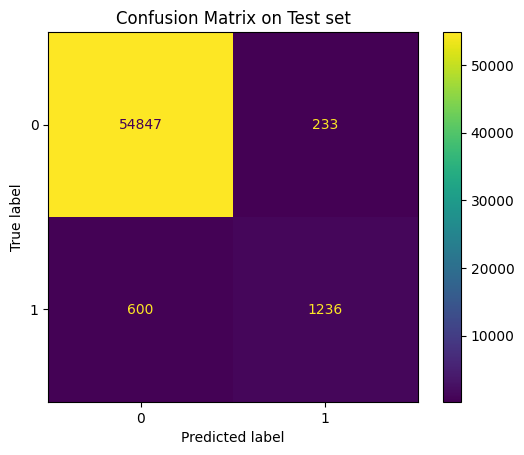

In [32]:
## predictions produced by the model
Y_train_predF = gridsearchF.predict(X_train)
Y_test_predF = gridsearchF.predict(X_test)
## probabilities produced by the model
Y_train_probaF = gridsearchF.predict_proba(X_train)
Y_test_probaF = gridsearchF.predict_proba(X_test)

## F1-score of the model
print("f1-score on training set : ", f1_score(Y_train, Y_train_predF))
print("f1-score on test set : ", f1_score(Y_test, Y_test_predF))

# plot
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(gridsearchF, X_test, Y_test, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

Names of columns corresponding to each coefficient:  ['age', 'total_pages_visited', 'country_Germany', 'country_UK', 'country_US', 'new_user_1', 'source_Direct', 'source_Seo']


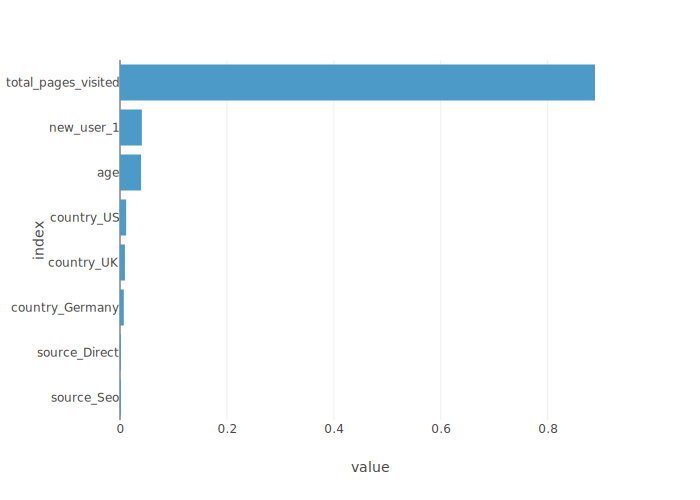

In [33]:
# feature importance
column_names = []
for name, step, features_list in preprocessor.transformers_: # loop over steps of ColumnTransformer
    if name == 'num': # if pipeline is for numeric variables
        features = features_list # just get the names of columns to which it has been applied
    else: # if pipeline is for categorical variables
        features = step.get_feature_names_out() # get output columns names from OneHotEncoder
    column_names.extend(features) # concatenate features names

print("Names of columns corresponding to each coefficient: ", column_names)

# Create a pandas DataFrame
feature_importance = pd.DataFrame(index = column_names, data = gridsearchF.best_estimator_.feature_importances_, columns=["feature_importances"])
feature_importance = feature_importance.sort_values(by = 'feature_importances')

# Plot coefficients
fig = px.bar(feature_importance, orientation = 'h')
fig.update_layout(showlegend = False, 
                  margin = {'l': 120} # to avoid cropping of column names
                 )
fig.show()

In [66]:
import joblib
# saving model
joblib.dump(gridsearchF, "models/gridsearchF.joblib")

['models/gridsearchF.joblib']

### 4.2.2 Model 2

##### model

In [34]:
# Perform grid search
print("Grid search...")
classifierF2 = RandomForestClassifier()

# Grid of values to be tested
params = {
    'max_depth': [6, 7, 8, 10],
    'min_samples_leaf': [5, 6, 7],
    'min_samples_split': [4, 5, 6, 7, 8],
    'n_estimators': [10, 15, 20]
}
gridsearchF2 = GridSearchCV(classifierF2, param_grid = params, cv = 10) # cv : the number of folds to be used for CV
gridsearchF2.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearchF2.best_params_)
print("Best validation accuracy : ", gridsearchF2.best_score_)

Grid search...
...Done.
Best hyperparameters :  {'max_depth': 8, 'min_samples_leaf': 5, 'min_samples_split': 4, 'n_estimators': 15}
Best validation accuracy :  0.9861726092494264


f1-score on training set :  0.7679478432264424
f1-score on test set :  0.7433950804737322


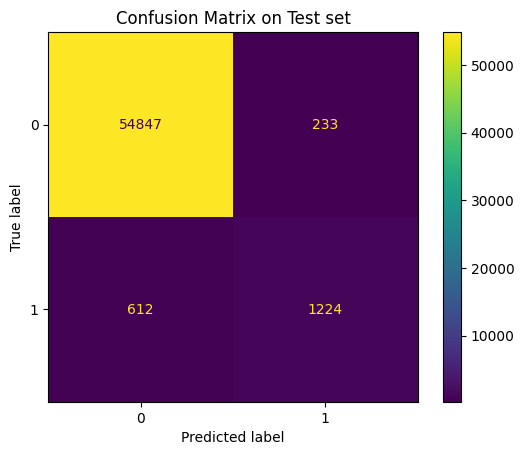

In [35]:
## predictions produced by the model
Y_train_predF2 = gridsearchF2.predict(X_train)
Y_test_predF2 = gridsearchF2.predict(X_test)
## probabilities produced by the model
Y_train_probaF2 = gridsearchF2.predict_proba(X_train)
Y_test_probaF2 = gridsearchF2.predict_proba(X_test)

## F1-score of the model
print("f1-score on training set : ", f1_score(Y_train, Y_train_predF2))
print("f1-score on test set : ", f1_score(Y_test, Y_test_predF2))

# plot
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(gridsearchF2, X_test, Y_test, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

Names of columns corresponding to each coefficient:  ['age', 'total_pages_visited', 'country_Germany', 'country_UK', 'country_US', 'new_user_1', 'source_Direct', 'source_Seo']


,feature_importances
source_Direct,0.001155
source_Seo,0.001360
country_Germany,0.006259
country_US,0.008629
country_UK,0.012527
age,0.027407
new_user_1,0.041129
total_pages_visited,0.901534


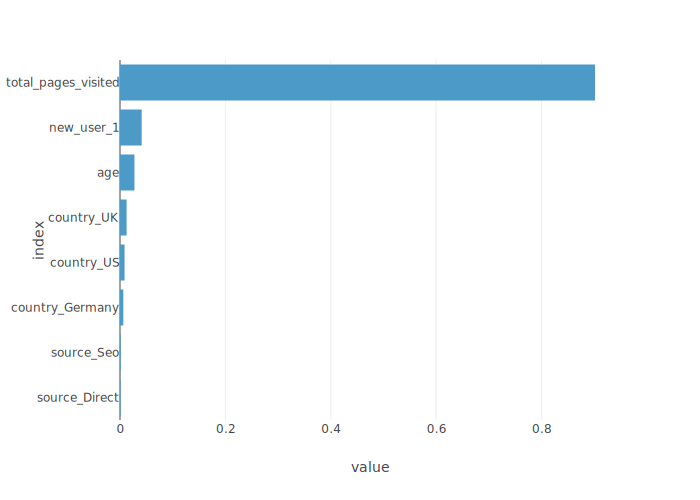

In [36]:
# feature importance
column_names = []
for name, step, features_list in preprocessor.transformers_: # loop over steps of ColumnTransformer
    if name == 'num': # if pipeline is for numeric variables
        features = features_list # just get the names of columns to which it has been applied
    else: # if pipeline is for categorical variables
        features = step.get_feature_names_out() # get output columns names from OneHotEncoder
    column_names.extend(features) # concatenate features names

print("Names of columns corresponding to each coefficient: ", column_names)

# Create a pandas DataFrame
feature_importance = pd.DataFrame(index = column_names, data = gridsearchF2.best_estimator_.feature_importances_, columns=["feature_importances"])
feature_importance = feature_importance.sort_values(by = 'feature_importances')
display(feature_importance)

# Plot coefficients
fig = px.bar(feature_importance, orientation = 'h')
fig.update_layout(showlegend = False, 
                  margin = {'l': 120} # to avoid cropping of column names
                 )
fig.show()

##### classification report

In [37]:
print("Classification report on train set:")
Y_train_predF2 = gridsearchF2.predict(X_train)
print(classification_report(Y_train, Y_train_predF2))

print("Classification report on test set:")
Y_test_predF2 = gridsearchF2.predict(X_test)
print(classification_report(Y_test, Y_test_predF2))

Classification report on train set:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    220320
           1       0.87      0.69      0.77      7344

    accuracy                           0.99    227664
   macro avg       0.93      0.84      0.88    227664
weighted avg       0.99      0.99      0.99    227664

Classification report on test set:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     55080
           1       0.84      0.67      0.74      1836

    accuracy                           0.99     56916
   macro avg       0.91      0.83      0.87     56916
weighted avg       0.98      0.99      0.98     56916



    - decision trees and random forest better than logistic regression
    - however, the second random forest seems slightly better

In [39]:
# saving model
joblib.dump(gridsearchF2, "models/gridsearchF2.joblib")

['models/gridsearchF2.joblib']

# 5. ExtraTreesClassifier

This class implements a meta estimator that fits a number of randomized decision trees (a.k.a. extra-trees) on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

In [40]:
from sklearn.ensemble import ExtraTreesClassifier

## 5.1 XTC with bootstrap

In [41]:
print("Grid search...")
etc1 = ExtraTreesClassifier(bootstrap=True)

# Grid of values to be tested
params = {
    'n_estimators': [50, 100, 150],
    'max_depth': [8, 10, 11, 12],
    'min_samples_leaf': [2, 5, 6, 7],
    'min_samples_split': [5, 8, 9, 10, 11]
}
gridsearchXT1 = GridSearchCV(etc1, param_grid = params, cv = 10) # cv : the number of folds to be used for CV
gridsearchXT1.fit(X_train, Y_train)
print("...Done.")

Grid search...
...Done.


In [42]:
print("Best hyperparameters : ", gridsearchXT1.best_params_)
print("Best validation accuracy : ", gridsearchXT1.best_score_)

Best hyperparameters :  {'max_depth': 12, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best validation accuracy :  0.9854434692907741


In [43]:
## predictions produced by the model
Y_train_predXT1 = gridsearchXT1.predict(X_train)
Y_test_predXT1 = gridsearchXT1.predict(X_test)

In [44]:
print("Classification report on train set:")
print(classification_report(Y_train, Y_train_predXT1))

print("Classification report on test set:")
print(classification_report(Y_test, Y_test_predXT1))

Classification report on train set:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    220320
           1       0.93      0.59      0.73      7344

    accuracy                           0.99    227664
   macro avg       0.96      0.80      0.86    227664
weighted avg       0.98      0.99      0.98    227664

Classification report on test set:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     55080
           1       0.91      0.59      0.71      1836

    accuracy                           0.98     56916
   macro avg       0.95      0.79      0.85     56916
weighted avg       0.98      0.98      0.98     56916



In [79]:
print("10-fold cross-validation...")
scores = cross_val_score(gridsearchXT1, X_train, Y_train, cv=10, scoring="f1")
print('The cross-validated F1-score is : ', scores.mean())
print('The standard deviation is : ', scores.std())

10-fold cross-validation...
The cross-validated F1-score is :  0.7265702453574187
The standard deviation is :  0.015866655531398252


In [45]:
joblib.dump(gridsearchXT1, "models/gridsearchXT1.joblib")

['models/gridsearchXT1.joblib']

## 5.2 XTC with warm start

In [46]:
print("Grid search...")
etc2 = ExtraTreesClassifier(warm_start=True, bootstrap=True)

# Grid of values to be tested
params = {
    'n_estimators': [50, 100, 150],
    'max_depth': [8, 10, 11, 12],
    'min_samples_leaf': [2, 5, 6, 7],
    'min_samples_split': [5, 8, 9, 10, 11]
}
gridsearchXT2 = GridSearchCV(etc2, param_grid = params, cv = 10) # cv : the number of folds to be used for CV
gridsearchXT2.fit(X_train, Y_train)
print("...Done.")

Grid search...
...Done.


In [47]:
print("Best hyperparameters : ", gridsearchXT2.best_params_)
print("Best validation accuracy : ", gridsearchXT2.best_score_)

Best hyperparameters :  {'max_depth': 12, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best validation accuracy :  0.9854434652391724


In [48]:
## predictions produced by the model
Y_train_predXT2 = gridsearchXT2.predict(X_train)
Y_test_predXT2 = gridsearchXT2.predict(X_test)

In [49]:
print("Classification report on train set:")
print(classification_report(Y_train, Y_train_predXT2))

print("Classification report on test set:")
print(classification_report(Y_test, Y_test_predXT2))

Classification report on train set:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    220320
           1       0.93      0.59      0.72      7344

    accuracy                           0.99    227664
   macro avg       0.96      0.79      0.86    227664
weighted avg       0.98      0.99      0.98    227664

Classification report on test set:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     55080
           1       0.91      0.58      0.71      1836

    accuracy                           0.98     56916
   macro avg       0.95      0.79      0.85     56916
weighted avg       0.98      0.98      0.98     56916



In [50]:
joblib.dump(gridsearchXT2, "models/gridsearchXT2.joblib")

['models/gridsearchXT2.joblib']

# 6. SVM

In [51]:
from sklearn.svm import SVC

In [52]:
svc1 = SVC(C=0.5, gamma=0.0005, probability = True)
svc1.fit(X_train, Y_train)

SVC(C=0.5, gamma=0.0005, probability=True)

f1-score on training set :  0.6986833220796759
f1-score on test set :  0.6990291262135923


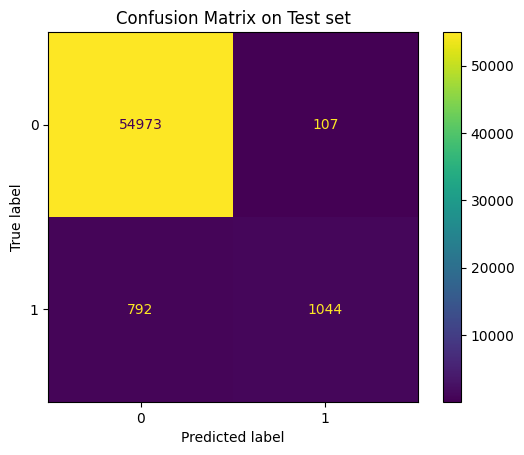

In [53]:
## predictions produced by the model
Y_train_predS1 = svc1.predict(X_train)
Y_test_predS1 = svc1.predict(X_test)
## probabilities produced by the model
Y_train_probaS1 = svc1.predict_proba(X_train)
Y_test_probaS1 = svc1.predict_proba(X_test)

## F1-score of the model
print("f1-score on training set : ", f1_score(Y_train, Y_train_predS1))
print("f1-score on test set : ", f1_score(Y_test, Y_test_predS1))

# plot
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(svc1, X_test, Y_test, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

In [54]:
joblib.dump(svc1, "models/svc1.joblib")

['models/svc1.joblib']

# 7. Adaboost all features LogReg

In [55]:
# import ensemble methods
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier

In [56]:
# Perform grid search
print("Grid search...")
logistic_regression = LogisticRegression(max_iter = 1000) # max_iter changed because of convergence warning
modelAB = AdaBoostClassifier(logistic_regression)

# Grid of values to be tested
params = {
    'base_estimator__C': [0.1, 0.5, 0.6, 0.7], # base_estimator__ prefix because C is a parameter from LogisticRegression! 
    'n_estimators': [5, 10, 20, 30, 40] # n_estimators is a hyperparameter of the ensemble method
}
print(params)
gridsearchAB = GridSearchCV(modelAB, param_grid = params, cv = 10) # cv : the number of folds to be used for CV
gridsearchAB.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearchAB.best_params_)
print("Best validation accuracy : ", gridsearchAB.best_score_)
print()
print("Accuracy on training set : ", gridsearchAB.score(X_train, Y_train))
print("Accuracy on test set : ", gridsearchAB.score(X_test, Y_test))

Grid search...
{'base_estimator__C': [0.1, 0.5, 0.6, 0.7], 'n_estimators': [5, 10, 20, 30, 40]}
...Done.
Best hyperparameters :  {'base_estimator__C': 0.7, 'n_estimators': 40}
Best validation accuracy :  0.9855357078644766

Accuracy on training set :  0.985544486611849
Accuracy on test set :  0.984802164593436


In [57]:
# predicted values
Y_train_predAB = gridsearchAB.predict(X_train)
Y_test_predAB = gridsearchAB.predict(X_test)

# Print scores
print("f1-score on training set : ", f1_score(Y_train, Y_train_predAB))
print("f1-score on test set : ", f1_score(Y_test, Y_test_predAB))

f1-score on training set :  0.7486059124589413
f1-score on test set :  0.7355548761846529


In [58]:
joblib.dump(gridsearchAB, "models/gridsearchAB.joblib")

['models/gridsearchAB.joblib']

# 8. Adaboost all features Decision Trees

In [59]:
# Perform grid search
print("Grid search...")
decision_tree = DecisionTreeClassifier()
modelABT = AdaBoostClassifier(decision_tree)

# Grid of values to be tested
params = {
    'base_estimator__max_depth': [3, 5, 10],
    'base_estimator__min_samples_leaf': [3, 5, 7],
    'base_estimator__min_samples_split': [2, 3, 4, 5],
    'n_estimators': [4, 6, 8, 10, 15]
}
print(params)
gridsearchABT = GridSearchCV(modelABT, param_grid = params, cv = 10) # cv : the number of folds to be used for CV
gridsearchABT.fit(X_train, Y_train)
print("...Done.")

Grid search...
{'base_estimator__max_depth': [3, 5, 10], 'base_estimator__min_samples_leaf': [3, 5, 7], 'base_estimator__min_samples_split': [2, 3, 4, 5], 'n_estimators': [4, 6, 8, 10, 15]}
...Done.


In [60]:
print("Best hyperparameters : ", gridsearchABT.best_params_)
print("Best validation accuracy : ", gridsearchABT.best_score_)
print()
print("Accuracy on training set : ", gridsearchABT.score(X_train, Y_train))
print("Accuracy on test set : ", gridsearchABT.score(X_test, Y_test))

Best hyperparameters :  {'base_estimator__max_depth': 5, 'base_estimator__min_samples_leaf': 5, 'base_estimator__min_samples_split': 2, 'n_estimators': 6}
Best validation accuracy :  0.9861989660767524

Accuracy on training set :  0.9862384918124956
Accuracy on test set :  0.9852941176470589


f1-score on training set :  0.7634936211972522
f1-score on test set :  0.7467473524962178


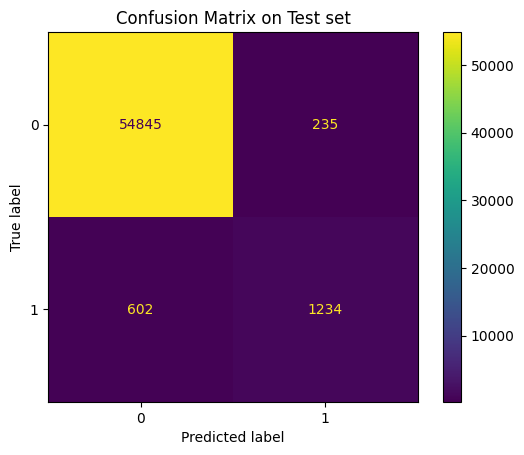

In [61]:
## predictions produced by the model
Y_train_predABT = gridsearchABT.predict(X_train)
Y_test_predABT = gridsearchABT.predict(X_test)
## probabilities produced by the model
Y_train_probaABT = gridsearchABT.predict_proba(X_train)
Y_test_probaABT = gridsearchABT.predict_proba(X_test)

## F1-score of the model
print("f1-score on training set : ", f1_score(Y_train, Y_train_predABT))
print("f1-score on test set : ", f1_score(Y_test, Y_test_predABT))

# plot
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(gridsearchABT, X_test, Y_test, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

In [62]:
joblib.dump(gridsearchABT, "models/gridsearchABT.joblib")

['models/gridsearchABT.joblib']

# 9. Summary of tested models

In [8]:
logall        = joblib.load('models/logall.joblib')
gridsearchLR  = joblib.load('models/gridsearchLR.joblib')
gridsearchT   = joblib.load('models/gridsearchT.joblib')
gridsearchF   = joblib.load('models/gridsearchF.joblib')
gridsearchF2  = joblib.load('models/gridsearchF2.joblib')
gridsearchXT1 = joblib.load('models/gridsearchXT1.joblib')
gridsearchXT2 = joblib.load('models/gridsearchXT2.joblib')
svc1          = joblib.load('models/svc1.joblib')
gridsearchAB  = joblib.load('models/gridsearchAB.joblib')
gridsearchABT = joblib.load('models/gridsearchABT.joblib')

In [9]:
Y_train_predA   = logall.predict(X_train)
Y_train_predLR  = gridsearchLR.predict(X_train)
Y_train_predT   = gridsearchT.predict(X_train)
Y_train_predF   = gridsearchF.predict(X_train)
Y_train_predF2  = gridsearchF2.predict(X_train)
Y_train_predXT1 = gridsearchXT1.predict(X_train)
Y_train_predXT2 = gridsearchXT2.predict(X_train)
Y_train_predS1  = svc1.predict(X_train)
Y_train_predAB  = gridsearchAB.predict(X_train)
Y_train_predABT = gridsearchABT.predict(X_train)

In [10]:
Y_test_predA   = logall.predict(X_test)
Y_test_predLR  = gridsearchLR.predict(X_test)
Y_test_predT   = gridsearchT.predict(X_test)
Y_test_predF   = gridsearchF.predict(X_test)
Y_test_predF2  = gridsearchF2.predict(X_test)
Y_test_predXT1 = gridsearchXT1.predict(X_test)
Y_test_predXT2 = gridsearchXT2.predict(X_test)
Y_test_predS1  = svc1.predict(X_test)
Y_test_predAB  = gridsearchAB.predict(X_test)
Y_test_predABT = gridsearchABT.predict(X_test)

In [11]:
results = pd.DataFrame(columns=["model", "name_model", "f1-score_train", "f1-score_test", "recall", "precision"])

model = ["LogReg", "GridSearch_LogReg", "Decision_Tree", "Random_Forest", "Random_Forest",
        "ExtraTreeClassifier_bootstrap", "ExtraTreeClassifier_warmstart", "SVM", "Adaboost_logReg", "Adaboost_DT"]
name_model = ["logall", "gridsearchLR", "gridsearchT", "gridsearchF", "gridsearchF2",
              "gridsearchXT1", "gridsearchXT2", "svc1", "gridsearchAB", "gridsearchABT"]

fscoretrain = [f1_score(Y_train, Y_train_predA), f1_score(Y_train, Y_train_predLR), f1_score(Y_train, Y_train_predT), f1_score(Y_train, Y_train_predF), f1_score(Y_train, Y_train_predF2),
               f1_score(Y_train, Y_train_predXT1), f1_score(Y_train, Y_train_predXT2), f1_score(Y_train, Y_train_predS1), f1_score(Y_train, Y_train_predAB), f1_score(Y_train, Y_train_predABT)]

fscore = [f1_score(Y_test, Y_test_predA), f1_score(Y_test, Y_test_predLR), f1_score(Y_test, Y_test_predT), f1_score(Y_test, Y_test_predF), f1_score(Y_test, Y_test_predF2),
          f1_score(Y_test, Y_test_predXT1), f1_score(Y_test, Y_test_predXT2), f1_score(Y_test, Y_test_predS1), f1_score(Y_test, Y_test_predAB), f1_score(Y_test, Y_test_predABT)]

recall = [recall_score(Y_test, Y_test_predA), recall_score(Y_test, Y_test_predLR), recall_score(Y_test, Y_test_predT), recall_score(Y_test, Y_test_predF), recall_score(Y_test, Y_test_predF2),
          recall_score(Y_test, Y_test_predXT1), recall_score(Y_test, Y_test_predXT2), recall_score(Y_test, Y_test_predS1), recall_score(Y_test, Y_test_predAB), recall_score(Y_test, Y_test_predABT)]

precision = [precision_score(Y_test, Y_test_predA), precision_score(Y_test, Y_test_predLR), precision_score(Y_test, Y_test_predT), precision_score(Y_test, Y_test_predF), precision_score(Y_test, Y_test_predF2),
            precision_score(Y_test, Y_test_predXT1), precision_score(Y_test, Y_test_predXT2), precision_score(Y_test, Y_test_predS1), precision_score(Y_test, Y_test_predAB), precision_score(Y_test, Y_test_predABT)]

In [12]:
results["model"] = model
results["name_model"] = name_model
results["f1-score_train"] = fscoretrain
results["f1-score_test"] = fscore
results["recall"] = recall
results["precision"] = precision
results

,model,name_model,f1-score_train,f1-score_test,recall,precision
0,LogReg,logall,0.765451,0.755435,0.681373,0.847561
1,GridSearch_LogReg,gridsearchLR,0.765070,0.753553,0.678649,0.847043
2,Decision_Tree,gridsearchT,0.774067,0.741798,0.665033,0.838599
3,Random_Forest,gridsearchF,0.776185,0.747958,0.673203,0.841389
4,Random_Forest,gridsearchF2,0.767948,0.743395,0.666667,0.840082
5,ExtraTreeClassifier_bootstrap,gridsearchXT1,0.725355,0.712773,0.586601,0.908094
6,ExtraTreeClassifier_warmstart,gridsearchXT2,0.718763,0.709635,0.581699,0.909710
7,SVM,svc1,0.698683,0.699029,0.568627,0.907037
8,Adaboost_logReg,gridsearchAB,0.748606,0.735555,0.655229,0.838328
9,Adaboost_DT,gridsearchABT,0.763494,0.746747,0.672113,0.840027


# 10. Voting

    - logall: best F1-score and recall
    - gridsearchLR: second best F1-score and recall on the testset
        'C': 0.15
    - gridsearchXT1: high precision but low f1-score and recall
        etc1 = ExtraTreesClassifier(bootstrap=True)
        {'max_depth': 12, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier

In [15]:
modelGSLR = LogisticRegression(C=0.15)

classifierRF = DecisionTreeClassifier(max_depth=12, min_samples_leaf=2, min_samples_split=10)
modelXT1 = ExtraTreesClassifier(max_depth=12, min_samples_leaf=2, min_samples_split=10, bootstrap=True, n_estimators=10)

In [18]:
# Voting
voting = VotingClassifier(estimators=[("LogReg", logall), ("Gs_LogReg", modelGSLR), ("XT1", modelXT1)], weights=[2, 2, 1])
voting.fit(X_train, Y_train)

VotingClassifier(estimators=[('LogReg', LogisticRegression()),
                             ('Gs_LogReg', LogisticRegression(C=0.15)),
                             ('XT1',
                              ExtraTreesClassifier(bootstrap=True, max_depth=12,
                                                   min_samples_leaf=2,
                                                   min_samples_split=10,
                                                   n_estimators=10))],
                 weights=[2, 2, 1])

In [19]:
for clf, label in zip([logall, modelGSLR, modelXT1, voting], ['LogReg', 'Gs_LogReg', 'XT1', 'Voting']):
    scores = cross_val_score(clf, X_test, Y_test, scoring='f1', cv=10)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.75 (+/- 0.02) [LogReg]
Accuracy: 0.75 (+/- 0.02) [Gs_LogReg]
Accuracy: 0.71 (+/- 0.02) [XT1]
Accuracy: 0.75 (+/- 0.02) [Voting]


##### performances

f1-score on training set :  0.7648703801677879
f1-score on test set :  0.7538601271571298


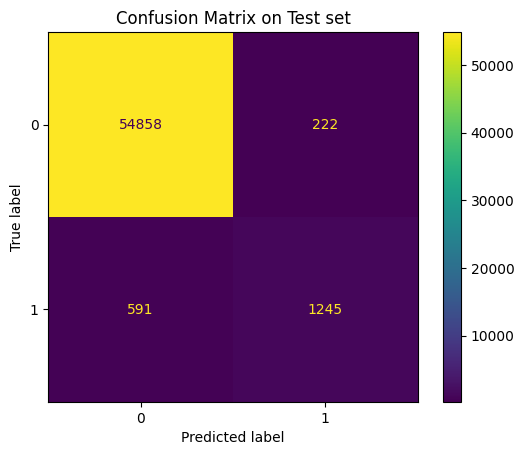

In [20]:
## predictions produced by the model
Y_train_pred = voting.predict(X_train)
Y_test_pred = voting.predict(X_test)

## F1-score of the model
print("f1-score on training set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

# plot
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(voting, X_test, Y_test, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

In [21]:
print("Classification report on train set:")
print(classification_report(Y_train, Y_train_pred))

print("Classification report on test set:")
print(classification_report(Y_test, Y_test_pred))

Classification report on train set:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    220320
           1       0.86      0.69      0.76      7344

    accuracy                           0.99    227664
   macro avg       0.92      0.84      0.88    227664
weighted avg       0.99      0.99      0.99    227664

Classification report on test set:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     55080
           1       0.85      0.68      0.75      1836

    accuracy                           0.99     56916
   macro avg       0.92      0.84      0.87     56916
weighted avg       0.98      0.99      0.98     56916



In [23]:
print("10-fold cross-validation...")
scores = cross_val_score(voting, X_train, Y_train, cv=10, scoring="f1")
print('The cross-validated F1-score is : ', scores.mean())
print('The standard deviation is : ', scores.std())

10-fold cross-validation...
The cross-validated F1-score is :  0.7649391133019832
The standard deviation is :  0.007759773762831548


In [24]:
joblib.dump(voting, "models/voting.joblib")

['models/voting.joblib']

##### voting on the full dataset

In [25]:
X_full = preprocessor.fit_transform(X)
voting.fit(X_full, Y)

VotingClassifier(estimators=[('LogReg', LogisticRegression()),
                             ('Gs_LogReg', LogisticRegression(C=0.15)),
                             ('XT1',
                              ExtraTreesClassifier(bootstrap=True, max_depth=12,
                                                   min_samples_leaf=2,
                                                   min_samples_split=10,
                                                   n_estimators=10))],
                 weights=[2, 2, 1])

f1-score on full set :  0.7623486682808717


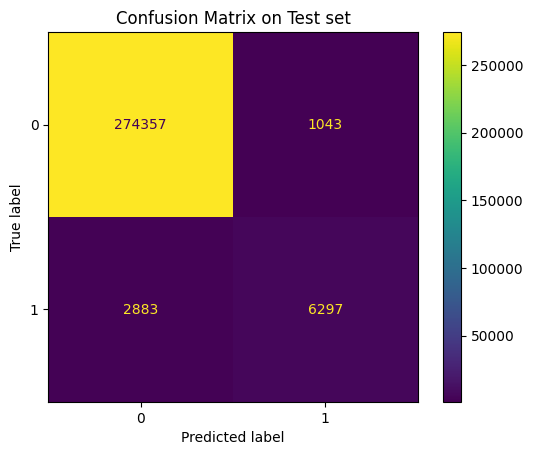

In [26]:
## predictions produced by the model
Y_full_pred = voting.predict(X_full)

## F1-score of the model
print("f1-score on full set : ", f1_score(Y, Y_full_pred))

# plot
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(voting, X_full, Y, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

In [27]:
print("Classification report on full set:")
print(classification_report(Y, Y_full_pred))

Classification report on full set:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    275400
           1       0.86      0.69      0.76      9180

    accuracy                           0.99    284580
   macro avg       0.92      0.84      0.88    284580
weighted avg       0.99      0.99      0.99    284580



# 11. Model of the test data set

In [28]:
# Read data without labels
data_without_labels = pd.read_csv('src/conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

Prediction set (without labels) : (31620, 5)


In [29]:
# Warning : check consistency of features_list (must be the same than the features 
# used by your best classifier)
features_list =  ['country', 'age', 'new_user', 'source', 'total_pages_visited']

## from the orginial dataset
X = data.loc[:, features_list]
Y = data.loc[:, target_variable]

print('Explanatory variables : ', X.columns)

# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify = Y)
print("...Done.")

Explanatory variables :  Index(['country', 'age', 'new_user', 'source', 'total_pages_visited'], dtype='object')
Dividing into train and test sets...
...Done.


In [30]:
## test data set
X_without_labels = data_without_labels.loc[:, features_list]

In [31]:
# WARNING : PUT HERE THE SAME PREPROCESSING AS FOR YOUR TEST SET
# CHECK YOU ARE USING X_without_labels
# Create pipeline for numeric features
numeric_features = ['age', 'total_pages_visited']
numeric_transformer = StandardScaler()

# Create pipeline for categorical features
categorical_features = ['country', 'new_user', 'source']
categorical_transformer = Pipeline(
    steps=[
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# preprocessing on the train datasest
print("Encoding categorical features and standardizing numerical features...")
X_train = preprocessor.fit_transform(X_train)
print("...Done")

Encoding categorical features and standardizing numerical features...
...Done


In [32]:
## preprocessing on the test data set
print("Encoding categorical features and standardizing numerical features...")
X_without_labels = preprocessor.transform(X_without_labels)
print("...Done")

Encoding categorical features and standardizing numerical features...
...Done


- voting

In [33]:
# Make predictions and dump to file
data = {
    'converted': voting.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('src/conversion_data_test_predictions_voting.csv', index=False)